In [25]:
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
import re
import sys
import os

print("Libraries imported successfully.")

Libraries imported successfully.


In [26]:
jid = 'JVASP-816'
material_name = 'Aluminium'
plot_location = 'Plots/'
# --- Define file names ---
vasprun_file = jid+'/vasprun.xml'
kpoints_file = jid+'/KPOINTS'
output_plot_file = plot_location+jid+"_"+material_name+'_bandstructure_plot.png'

# --- Check if files exist ---
if not os.path.exists(vasprun_file):
    print(f"Error: File not found: {vasprun_file}", file=sys.stderr)
elif not os.path.exists(kpoints_file):
    print(f"Error: File not found: {kpoints_file}", file=sys.stderr)
else:
    print(f"Found input files: {vasprun_file}, {kpoints_file}")

Found input files: JVASP-816/vasprun.xml, JVASP-816/KPOINTS


# Parse vasprun.xml (Part 1: Initial Data)
This cell opens the vasprun.xml and KPOINTS files to extract the three most important pieces of information needed to start:

1. Fermi Energy (efermi): To set the 0 eV level.

1. Reciprocal Basis (rec_basis): To calculate k-point distances.

1. K-point Count (target_kpoints_count): To find the correct data block.

In [27]:
try:
    # Parse the XML file
    tree = ET.parse(vasprun_file)
    root = tree.getroot()

    # Get Fermi energy
    efermi_element = root.find("./calculation/dos/i[@name='efermi']")
    efermi = float(efermi_element.text.strip())
    print(f"Found Fermi Energy: {efermi}")

    # Get reciprocal lattice basis
    rec_basis_element = root.find("./structure[@name='finalpos']/crystal/varray[@name='rec_basis']")
    rec_basis = []
    for v in rec_basis_element.findall('v'):
        rec_basis.append([float(x) for x in v.text.strip().split()])
    rec_basis = np.array(rec_basis)
    print("Found Reciprocal Basis:")
    print(rec_basis)

    # Get the target k-point count from the KPOINTS file
    with open(kpoints_file, 'r') as f:
        lines = f.readlines()
        target_kpoints_count = int(lines[1].strip())
    print(f"Target k-points from KPOINTS file: {target_kpoints_count}")

except Exception as e:
    print(f"An error occurred in Cell 3: {e}", file=sys.stderr)

Found Fermi Energy: 6.87104034
Found Reciprocal Basis:
[[ 0.40148227 -0.14194544  0.        ]
 [ 0.          0.42583616  0.        ]
 [-0.20074114 -0.14194536  0.34769378]]
Target k-points from KPOINTS file: 210


# Parse vasprun.xml (Part 2: Find Correct Data)
vasprun.xml can contain multiple k-point sets. This cell finds the specific block that matches the number of k-points from your KPOINTS file (e.g., 210).

In [28]:
try:
    kpoints_sets = root.findall("./kpoints")
    eigenvalues_sets = root.findall("./calculation/projected/eigenvalues")

    found_kpoints_xml = None
    found_eigenvalues_xml = None

    # Check the k-point sets in vasprun.xml
    for i, kset in enumerate(kpoints_sets):
        klist = kset.find("varray[@name='kpointlist']")
        if klist is None:
            continue
        
        # Count k-points in this set
        kpts_in_set = len(klist.findall('v'))
        
        if kpts_in_set == target_kpoints_count:
            print(f"Found matching k-point set (Set {i+1}) with {kpts_in_set} k-points.")
            
            # Store the k-point coordinates
            kpts = []
            for v in klist.findall('v'):
                kpts.append([float(x) for x in v.text.strip().split()])
            found_kpoints_xml = np.array(kpts)
            
            # Assume corresponding eigenvalue set
            found_eigenvalues_xml = eigenvalues_sets[0].find("array/set")
            break
            
    if found_kpoints_xml is None:
        raise ValueError(f"Could not find a k-point set with {target_kpoints_count} k-points in {vasprun_file}")

except Exception as e:
    print(f"An error occurred in Cell 4: {e}", file=sys.stderr)

Found matching k-point set (Set 1) with 210 k-points.


# Parse vasprun.xml (Part 3: Extract and Shift Energies)
Now that we've found the correct data block, this cell loops through it to extract the energy for every band at every k-point for both spin channels. It then transposes the arrays and shifts them by the Fermi energy.

In [29]:
try:
    spin1_bands = []
    spin2_bands = []

    spin1_set = found_eigenvalues_xml.find('set[@comment="spin 1"]')
    spin2_set = found_eigenvalues_xml.find('set[@comment="spin 2"]')

    if spin1_set is None or spin2_set is None:
        raise ValueError("Could not find spin 1 and spin 2 eigenvalues. Check ISPIN=2.")

    # Parse spin 1 (Up)
    for k_set in spin1_set.findall('set'):
        energies = [float(r.text.strip().split()[0]) for r in k_set.findall('r')]
        spin1_bands.append(energies)

    # Parse spin 2 (Down)
    for k_set in spin2_set.findall('set'):
        energies = [float(r.text.strip().split()[0]) for r in k_set.findall('r')]
        spin2_bands.append(energies)

    # Convert to NumPy arrays and transpose
    # Shape becomes: [band_index, kpoint_index]
    spin1_bands = np.array(spin1_bands).T
    spin2_bands = np.array(spin2_bands).T

    # Shift by Fermi energy
    spin1_bands_shifted = spin1_bands - efermi
    spin2_bands_shifted = spin2_bands - efermi

    num_bands, num_kpoints = spin1_bands_shifted.shape
    print(f"Successfully parsed {num_bands} bands at {num_kpoints} k-points.")

except Exception as e:
    print(f"An error occurred in Cell 5: {e}", file=sys.stderr)

Successfully parsed 20 bands at 210 k-points.


# Parse KPOINTS File (Get Labels)
This cell reads the KPOINTS file to find the high-symmetry point labels (like $\Gamma, X, L$) and the index of the k-point they correspond to.

In [30]:
try:
    with open(kpoints_file, 'r') as f:
        lines = f.readlines()
    
    kpoint_lines = lines[3:] # Skip header
    labels_map = {} # Map k-point index to label
    
    current_label = None
    for i, line in enumerate(kpoint_lines):
        if i >= target_kpoints_count:
            break
            
        parts = line.strip().split()
        if not parts:
            continue
            
        if len(parts) > 4: # Label is present
            label = re.sub(r'\\(\w+)', r'\1', parts[4]) # Clean \Gamma -> Gamma
            if label != current_label:
                labels_map[i] = label
                current_label = label
                
    # Check the last k-point
    last_line_parts = kpoint_lines[target_kpoints_count-1].strip().split()
    if len(last_line_parts) > 4:
        label = re.sub(r'\\(\w+)', r'\1', last_line_parts[4])
        if (target_kpoints_count - 1) not in labels_map:
             labels_map[target_kpoints_count - 1] = label
             
    print(f"Found labels: {labels_map}")

except Exception as e:
    print(f"An error occurred in Cell 6: {e}", file=sys.stderr)

Found labels: {0: 'Gamma', 31: 'X', 48: 'W', 60: 'K', 94: 'Gamma', 122: 'L', 142: 'U', 154: 'W', 177: 'L', 197: 'K', 198: 'U', 209: 'X'}


# Calculate K-Point Distances (X-axis)
This cell creates the x-axis for the plot. It converts the k-points to Cartesian coordinates and calculates the cumulative distance between them, ensuring that path breaks (like L to U|K) are handled correctly.

In [31]:
try:
    # Convert k-points from fractional to cartesian
    kpoints_cart = np.dot(found_kpoints_xml, rec_basis)
    
    distances = [0.0]
    current_dist = 0.0
    
    segment_starts = sorted(labels_map.keys())
    
    # Calculate cumulative distance
    for i in range(1, len(kpoints_cart)):
        dist = np.linalg.norm(kpoints_cart[i] - kpoints_cart[i-1])
        
        # Check for path breaks (e.g., L to U|K)
        if (i) in segment_starts and (i-1) in segment_starts and i != 0:
             pass # Don't add distance
        else:
             current_dist += dist
             
        distances.append(current_dist)
        
    distances = np.array(distances)
    print(f"Successfully calculated distances for {len(distances)} k-points.")
    print(f"Total path length: {distances[-1]}")

except Exception as e:
    print(f"An error occurred in Cell 7: {e}", file=sys.stderr)

Successfully calculated distances for 210 k-points.
Total path length: 1.5782022760861771


# Plotting the Band Structure
This final cell uses all the data processed so far to generate the plot with matplotlib.

Plot saved to Plots/JVASP-816_Aluminium_bandstructure_plot.png


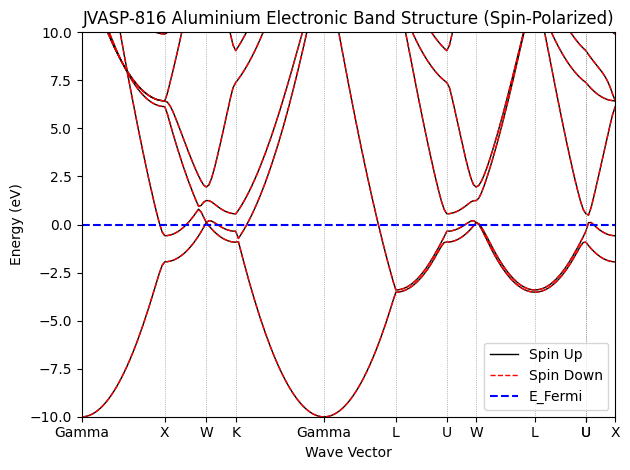

In [33]:
try:
    #plt.figure(figsize=(10, 6))
    plt.figure()
    
    # --- Plot bands ---
    for i in range(num_bands):
        # Spin 1 (Up) - solid black line
        plt.plot(distances, spin1_bands_shifted[i, :], 'k-', lw=1)
        # Spin 2 (Down) - dashed red line
        plt.plot(distances, spin2_bands_shifted[i, :], 'r--', lw=1)

    # --- Add Fermi level line ---
    plt.axhline(0.0, color='blue', linestyle='--', lw=1.5, label='E_Fermi')

    # --- Set x-ticks and labels ---
    label_indices = sorted(labels_map.keys())
    label_distances = [distances[i] for i in label_indices]
    label_names = [labels_map[i] for i in label_indices]
    
    plt.xticks(label_distances, label_names)
    plt.xlim(distances.min(), distances.max())
    
    # --- Add vertical grid lines for labels ---
    for d in label_distances:
        plt.axvline(d, color='gray', linestyle=':', lw=0.5)

    # --- Labels, Title, and Limits ---
    plt.xlabel("Wave Vector")
    plt.ylabel("Energy (eV)")
    plt.title(jid +" "+ material_name +" Electronic Band Structure (Spin-Polarized)")
    plt.ylim(-10, 10) # Set Y-axis limits (e.g., -10 to 10 eV)
    
    # --- Add legend ---
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='k', lw=1, label='Spin Up'),
        Line2D([0], [0], color='r', lw=1, linestyle='--', label='Spin Down'),
        Line2D([0], [0], color='blue', lw=1.5, linestyle='--', label='E_Fermi')
    ]
    plt.legend(handles=legend_elements, loc='best')

    plt.tight_layout()
    plt.savefig(output_plot_file)
    print(f"Plot saved to {output_plot_file}")
    
    # --- Show the plot in the notebook ---
    plt.show()

except Exception as e:
    print(f"An error occurred during plotting in Cell 8: {e}", file=sys.stderr)